In [1]:
#%matplotlib inline
from __future__ import print_function
import pylab

import numpy as np

import matplotlib.pyplot as plt
import time
import os
import pickle
import random

import pandas as pd

import random

#from category_encoders import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

plt.style.use('seaborn-white')

pylab.ion()

In [2]:
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi, tan, sinh, cosh, exp, tanh, log, log10
import scipy.special as ssf
import math

In [3]:
def psiHOpoint(n, x):
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHO(n, x):
    x=np.array(x)
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHOall(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)])

def HM(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)]).T

def FM(k, L, x): #k Fourier modes in the interval (-L,L)
    x=np.array(x)
    xkmat = np.reshape(x, [len(x),1])*np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)*np.ones([len(x),1])
    cosmodes = cos(xkmat*pi/L)/sqrt(L)
    sinmodes = sin(xkmat*pi/L)/sqrt(L)
    return np.concatenate((zeromode,cosmodes,sinmodes),axis=1)

def FCpsiHO(n, k, L) :#k Fourier coefficients for the nth harmonic oscillator wavefunction in (-L,L)
    coeff0 = np.array([integrate.quad(lambda x: psiHOpoint(n, x)/sqrt(2*L), -L, L)[0]])
    coeffcos = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*cos(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    coeffsin = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*sin(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    return np.concatenate((coeff0,coeffcos,coeffsin))

In [4]:
def FM0(k, L, x): #k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)
    cosmodes = cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def D2FM0(k, L, x): #second derivative of k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 0
    cosmodes = -(kvec*pi/L)**2*cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = -(kvec*pi/L)**2*sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def H_HO_FM_int(k, L):
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(x**2*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

def V_AHO(x):
    return -x**2/2-x+x**4/16

def H_AHO_FM_int(k, L, V): #V is the function that calculates the potential
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(2*V(x)*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

In [5]:
def make_lower(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        for j in range(i+1):
            mask[i, j] = 1
    mask = torch.from_numpy(mask)
    return mask

def make_diag(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        mask[i, i] = 1
    mask = torch.from_numpy(mask)
    return mask

## Variational Inference

In [6]:
#define QVI module
class QVI(nn.Module):  #QVI with any basis

    def __init__(self, Temp, n_ES, H_matrix):
        super(QVI, self).__init__()
        
        self.n_Ba = H_matrix.shape[0] #get size of basis set from Hamiltonian matrix
        self.n_EL = n_ES
        self.T = Temp
        self.H_MAT = torch.from_numpy(H_matrix)
        
        self.levels = torch.nn.Parameter(torch.from_numpy(np.random.uniform(1,2,self.n_EL+1)))
        self.levels.requires_grad = True
        
        self.var_BaC = torch.nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,[self.n_Ba, self.n_EL+1])))
        self.var_BaC.requires_grad = True
        
        self.mask = (make_lower(self.n_EL+1) - make_diag(self.n_EL+1) ) > 0 #convert to boolean
        self.diag = make_diag(self.n_EL+1) > 0 #convert to boolean   

        

    def forward(self):
        
        
        norms_BaC = torch.linalg.norm(self.var_BaC, dim = 0)
        var_BaC_N = self.var_BaC/norms_BaC #normalise the coefficients of basis states before each forward propagation

        loss_vNE = torch.sum(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1) ,\
                     torch.matmul(self.H_MAT, var_BaC_N)), self.diag) * F.softmin(self.levels, dim = 0))
        c_orth = 1000
        loss_orth = c_orth * torch.mean(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1),var_BaC_N) \
                                                                  , self.mask)**2)

        loss_VI = self.T*torch.sum(F.softmin(self.levels, dim = 0)*F.log_softmax(-1 * self.levels, dim = 0))
                                                             

        loss = loss_vNE + loss_VI + loss_orth
        return loss, loss_vNE, loss_VI, loss_orth, self.levels #, self.var_BaC
    
    

In [7]:
def main_train_states_QVI(G, epochs = 100000, step = 1e-3):
    
    optimiser = torch.optim.Adam(G.parameters(), lr=step)
    
    loss_hist = np.zeros((epochs,), dtype = float)
    loss_vNE_hist = np.zeros((epochs,), dtype = float)
    loss_VI_hist = np.zeros((epochs,), dtype = float)
    loss_orth_hist = np.zeros((epochs,), dtype = float)

    levels_hist = []
    
    for i in range(epochs):
        [loss, loss_vNE, loss_VI, loss_orth, levels] = G()
    
    
        loss_hist[i] = loss.tolist()
        loss_vNE_hist[i] = loss_vNE.tolist()
        loss_VI_hist[i] = loss_VI.tolist()
        loss_orth_hist[i] = loss_orth.tolist()
        levels_hist.append(levels.tolist())
    
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if i % 10000 == 0:
                print('Batch number ', i)
                print('Loss: ', loss_hist[i])
                print('Loss_orth: ', loss_orth_hist[i])
                print('Loss_vNE: ', loss_vNE_hist[i])
                print('Loss_vI: ', loss_VI_hist[i])
                print('@----------------------------------------------------------@')
                #writer.add_summary(summary, i)
                #writer.flush()
        
        
    var_BaC = G.var_BaC
    norms_BaC = torch.linalg.norm(var_BaC, dim = 0)
    var_BaC_N = (var_BaC / norms_BaC).detach().numpy() #normalise the coefficients of basis states
    levels_hist = np.array(levels_hist)

    
    ##Sort energy levels and associated coefficients of basis states in ascending order
    fin_EL = G.levels
    fin_EL = fin_EL.detach().numpy()
    fin_EL_argsort = fin_EL.argsort()
    levels_hist = levels_hist[:, fin_EL_argsort]
    var_BaC_N = var_BaC_N[:, fin_EL_argsort]
    fin_EL = fin_EL[fin_EL_argsort]
    #EL_ranks = np.empty_like(fin_EL_argsort)
    #EL_ranks[fin_EL_argsort] = np.arange(len(fin_EL))
    
    
    return loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, var_BaC_N, fin_EL
    

## Fourier Basis

## High temperature (T = 2)

In [8]:
n_EL = 10
n_FM = 20
box_len = 10
T = 2

H_AHO_FM = H_AHO_FM_int(n_FM, box_len,  V_AHO)

In [9]:
qvi_AHO_FM = QVI(T, n_EL, H_AHO_FM)
epochs = 100000
step = 1e-3

[loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, var_FC_N, levels_fin] = \
                                                                main_train_states_QVI(qvi_AHO_FM, epochs, step)

/home/scl489/.env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Batch number  0
Loss:  244.46962842715854
Loss_orth:  28.294215326563293
Loss_vNE:  220.87298543472312
Loss_vI:  -4.697572334127866
@----------------------------------------------------------@
Batch number  10000
Loss:  -5.177820956050056
Loss_orth:  4.549240480590989e-05
Loss_vNE:  -3.675913336558926
Loss_vI:  -1.5019531118959355
@----------------------------------------------------------@
Batch number  20000
Loss:  -5.230230814636248
Loss_orth:  4.664654826743843e-07
Loss_vNE:  -3.6125967121929863
Loss_vI:  -1.617634568908744
@----------------------------------------------------------@
Batch number  30000
Loss:  -5.230289031479493
Loss_orth:  4.648716421542573e-07
Loss_vNE:  -3.612454057316276
Loss_vI:  -1.6178354390348597
@----------------------------------------------------------@
Batch number  40000
Loss:  -5.230293956278015
Loss_orth:  5.205725820689184e-07
Loss_vNE:  -3.6124099199623596
Loss_vI:  -1.6178845568882372
@----------------------------------------------------------@
Ba

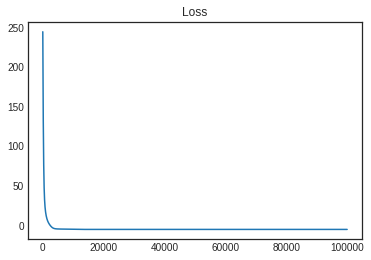

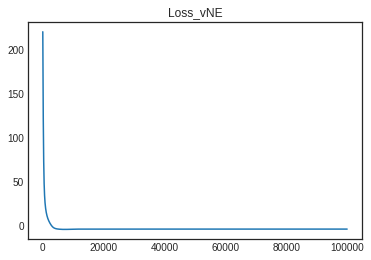

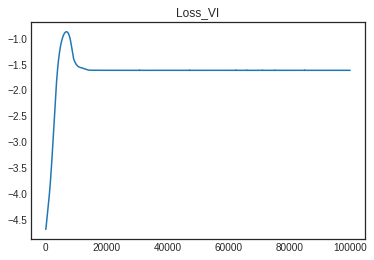

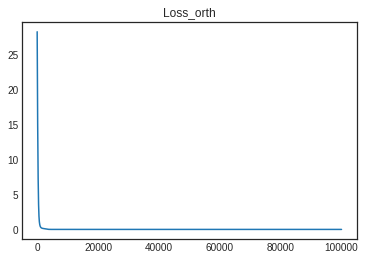

In [10]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_vNE_hist)
plt.title("Loss_vNE")
plt.show()
plt.plot(np.arange(epochs), loss_VI_hist)
plt.title("Loss_VI")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

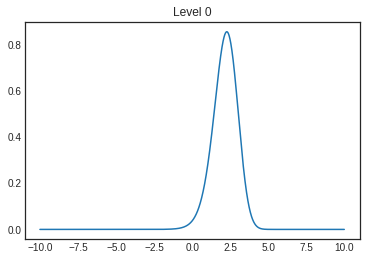

Square integrated over the region: 1.0000000000000215


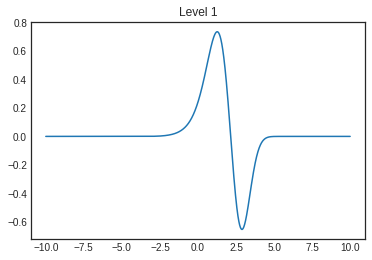

Square integrated over the region: 1.0000000000000213


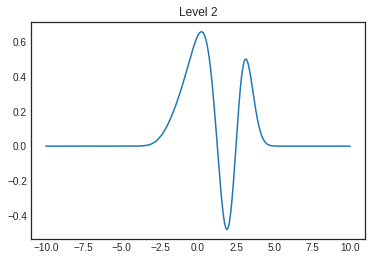

Square integrated over the region: 1.0000000000000204


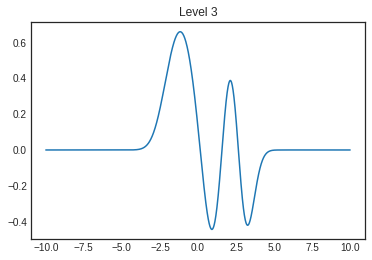

Square integrated over the region: 1.0000000000000215


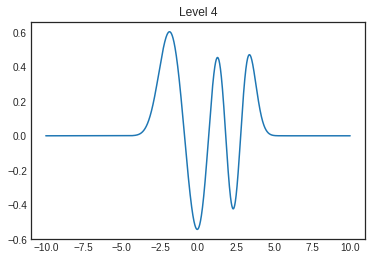

Square integrated over the region: 1.0000000000000213


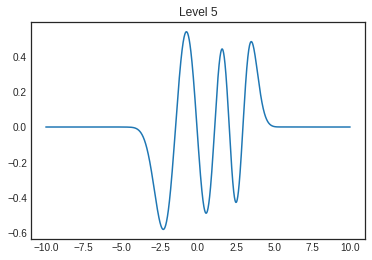

Square integrated over the region: 1.0000000000000209


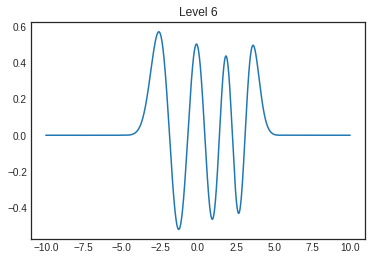

Square integrated over the region: 1.0000000000000213


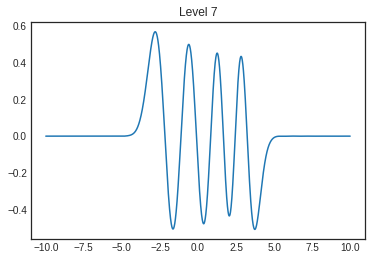

Square integrated over the region: 1.000000000000021


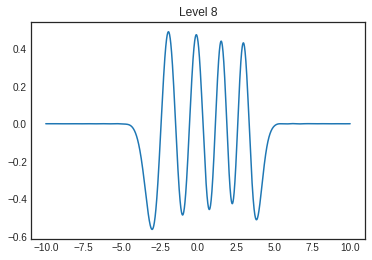

Square integrated over the region: 1.0000000000000213


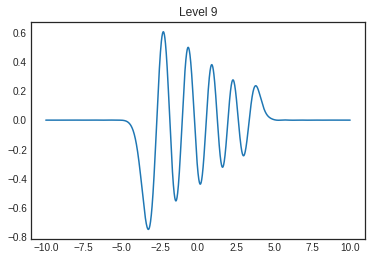

Square integrated over the region: 1.0000000000000215


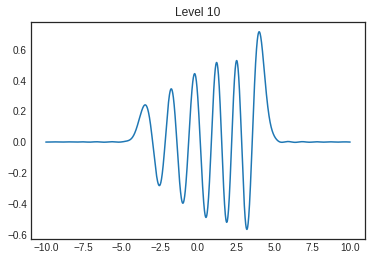

Square integrated over the region: 1.000000000000021


In [11]:
x = np.arange(-10, 10 , 0.01)
k = n_FM
L = box_len
Y = FM(k, L, x)

SUP = np.matmul(Y, var_FC_N)

for i in range(11):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

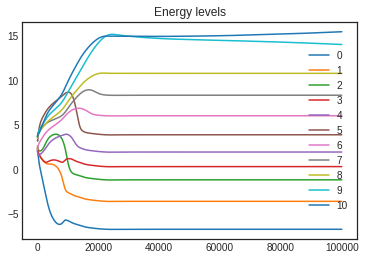

In [12]:
for i in range(11):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

## Higher temperature (T = 4)

In [18]:
n_EL = 10
n_FM = 20
box_len = 10
T = 4

H_AHO_FM = H_AHO_FM_int(n_FM, box_len,  V_AHO)

In [19]:
qvi_AHO_FM = QVI(T, n_EL, H_AHO_FM)
epochs = 100000
step = 1e-3

[loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, var_FC_N, levels_fin] = \
                                                                main_train_states_QVI(qvi_AHO_FM, epochs, step)

Batch number  0
Loss:  242.13735277353686
Loss_orth:  26.797702313917863
Loss_vNE:  224.78242198154072
Loss_vI:  -9.442771521921701
@----------------------------------------------------------@
Batch number  10000
Loss:  -7.675843174818833
Loss_orth:  0.0001348098176155431
Loss_vNE:  -1.4840578327008385
Loss_vI:  -6.19192015193561
@----------------------------------------------------------@
Batch number  20000
Loss:  -7.731612475910783
Loss_orth:  3.42434779506176e-07
Loss_vNE:  -1.3873405099396385
Loss_vI:  -6.344272308405923
@----------------------------------------------------------@
Batch number  30000
Loss:  -7.731619007746443
Loss_orth:  1.800782908744464e-07
Loss_vNE:  -1.3873500081322736
Loss_vI:  -6.344269179692461
@----------------------------------------------------------@
Batch number  40000
Loss:  -7.731618397104512
Loss_orth:  1.292651895765829e-07
Loss_vNE:  -1.3873557278272506
Loss_vI:  -6.344262798542451
@----------------------------------------------------------@
Batch

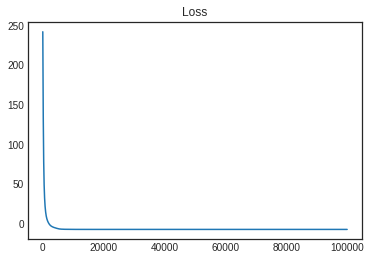

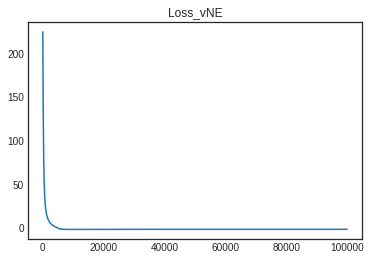

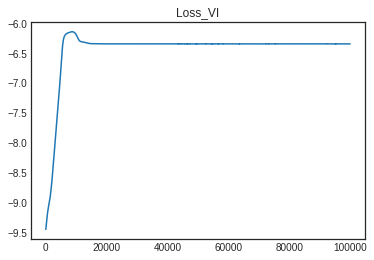

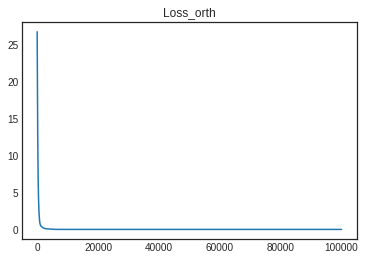

In [20]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_vNE_hist)
plt.title("Loss_vNE")
plt.show()
plt.plot(np.arange(epochs), loss_VI_hist)
plt.title("Loss_VI")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

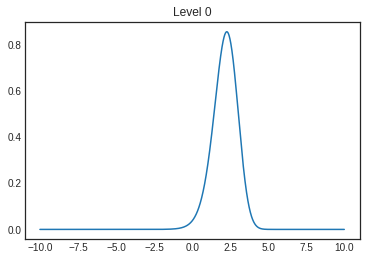

Square integrated over the region: 1.0000000000000215


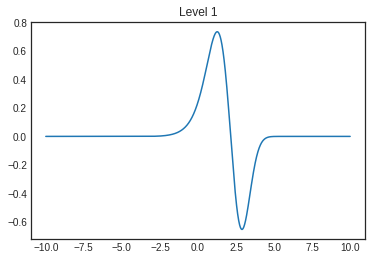

Square integrated over the region: 1.0000000000000213


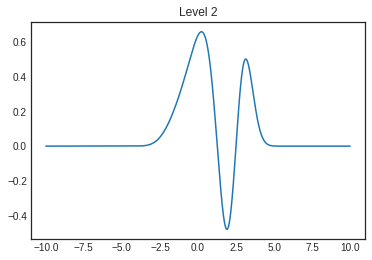

Square integrated over the region: 1.000000000000021


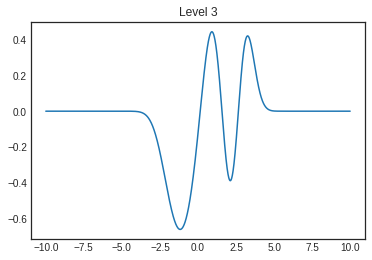

Square integrated over the region: 1.0000000000000215


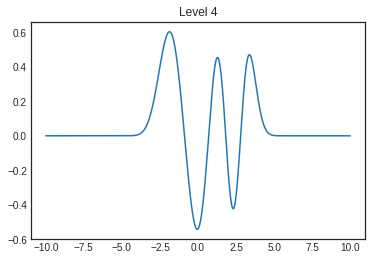

Square integrated over the region: 1.0000000000000213


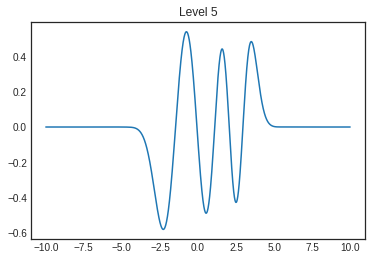

Square integrated over the region: 1.0000000000000213


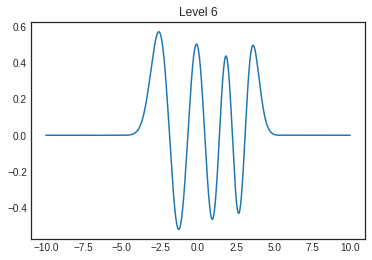

Square integrated over the region: 1.0000000000000215


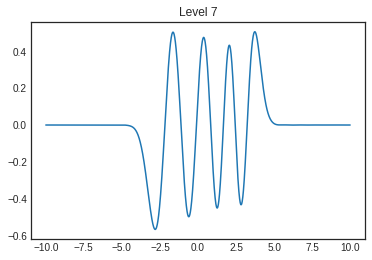

Square integrated over the region: 1.0000000000000213


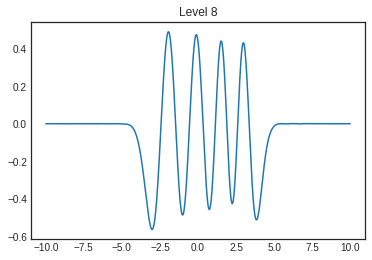

Square integrated over the region: 1.0000000000000215


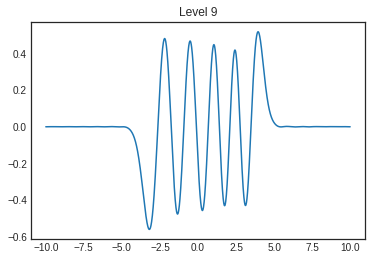

Square integrated over the region: 1.0000000000000215


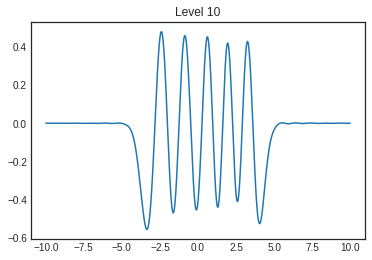

Square integrated over the region: 1.000000000000021


In [21]:
x = np.arange(-10, 10 , 0.01)
k = n_FM
L = box_len
Y = FM(k, L, x)

SUP = np.matmul(Y, var_FC_N)

for i in range(11):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

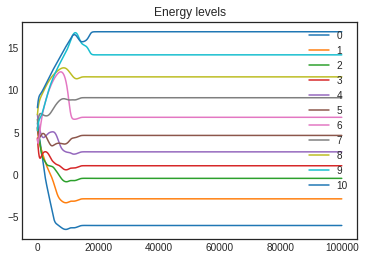

In [22]:
for i in range(11):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()